In [3]:
sc

Java ref type org.apache.spark.api.java.JavaSparkContext id 0 

# Understanding Vehicular Fatalities:
### An Overview of Fatal Crash Data 1975-2014
___

### Contents

 * Introduction
 * Load Libraries and Data Sources
 * Vehicle Analysis: Comparing Manufacturers
 * Driver Analysis: Dangerous Behaviors
     * Speeding
     * Drinking
 * Crash Location Analysis: Choropleth Map
 * Conclusions

 
___

### Introduction

Producers and consumers of automobiles have strong incentives to prefer safer vehicles. As horrific and tragic as traffic accidents are for the obvious reasons, they also impact a manufacturer's image in the marketplace. Auto manufacturers strive to be the safest car on the road to avoid loss of life and limb, and are keenly aware of the impact negative publicity can have on business.

With data collected by the NHTSA Fatality Analysis Reporting System (FARS) from 1975-2014, we will explore the following questions:

>**How does the safety profile of different manufacturers compare to eachother?**<br><br>
>**In the event of a crash, which factors are associated with fatality?**

Note: _In an effort to circumscribe the scope of this notebook, the historical table has been filtered to match the columns available in the 2014 data.  Please refer to the [FARS website](http://www-fars.nhtsa.dot.gov/Main/index.aspx) for the original, unaltered data._

___

### Load Libraries and Data Sources

We will begin by loading the necessary libraries into R, then connecting to our recent and archived data sources.  Finally, we'll connect to Spark and load the historical data into a Spark DataFrame.

In [1]:
## Load libraries (This can take a minute or two)
install.packages(c('sparklyr', "noncensus", "httr", "maptools", "gridExtra"))
library(sparklyr, quietly = T)
library(dplyr, quietly = T)
library(noncensus, quietly = T)
library(httr, quietly = T)
library(maptools, quietly = T)
library(RPostgreSQL, quietly = T)
library(ggplot2, quietly = T)
library(gridExtra, quietly = T)
library(DBI, quietly = T)
library(scales, quietly = T)
library(ggmap, quietly = T)

Installing packages into ‘/gpfs/global_fs01/sym_shared/YPProdSpark/user/s4f2-8c8d6c01f4427a-511d20592d9b/R/libs’
(as ‘lib’ is unspecified)

Attaching package: ‘dplyr’

The following objects are masked from ‘package:SparkR’:

    arrange, between, collect, contains, count, cume_dist, dense_rank,
    desc, distinct, explain, filter, first, group_by, intersect, lag,
    last, lead, mutate, n, n_distinct, ntile, percent_rank, rename,
    row_number, sample_frac, select, sql, summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Checking rgeos availability: FALSE
 	Note: when rgeos is not available, polygon geometry 	computations in maptools depend on gpclib,
 	which has a restricted licence. It is disabled by default;
 	to enable gpclib, type gpclibPermit()

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine


Attaching

#### IBM Object Storage - Archived FARS Data

Archival data is sometimes stored separately from more recent records.  To approximate this real life scenario the FARS data from 1975-2013 has been loaded into IBM Cloud Object Storage.  It is then seamlessly incorporated into our Jupyter Notebook in the cell below.  

To keep credentials private while sharing, the tag `# @hidden_cell` has been added to the beginning of the cell below.  Adding this tag will allow the code to run but hide the results in shared copies of the Notebook.  The password for our PostgreSQL database has also been hidden in this cell.

In [2]:
# @hidden_cell

# This function includes credentials to your Object Storage.
# You might want to remove those credentials before you share your notebook.
getObjectStorageFileWithCredentials_d7a568f8ac534bc48834f0e1762068f9 <- function(container, filename) {
    # This functions returns a textConnection object for a file
    # from Bluemix Object Storage V3.

    if(!require(httr)) install.packages('httr')
    if(!require(RCurl)) install.packages('RCurl')
    library(httr, RCurl)
    auth_url <- paste("https://identity.open.softlayer.com",'/v3/auth/tokens', sep= '')
    auth_args <- paste('{"auth": {"identity": {"password": {"user": {"domain": {"id": ', "47ea410d2b51478d9f29fade08fbefe4",'},"password": ',
                    "NSjRZ]?S8m5s,v*.",',"name": ', "admin_d56a5dec748317bd421ef7c9f98aa4b630d2c50d",'}},"methods": ["password"]}}}', sep='"')
    auth_response <- httr::POST(url = auth_url, body = auth_args)
    x_subject_token <-  headers(auth_response)[['x-subject-token']]
    auth_body <-  content(auth_response)
    access_url <-  unlist(lapply(auth_body[['token']][['catalog']], function(catalog){
        if((catalog[['type']] == 'object-store')){
            lapply(catalog[['endpoints']], function(endpoints){
                if(endpoints[['interface']] == 'public' && endpoints[['region_id']] == 'dallas') {
                    paste(endpoints[['url']], container, filename, sep='/')}
            })
        }
    }))
    data <- content(httr::GET(url = access_url, add_headers ("Content-Type" = "application/json", "X-Auth-Token" = x_subject_token)), as="text")
    textConnection(data)
}

options(scipen = 999)

postgresPW <- "YAUZZGKOVRPBFPVF"

#### PostgreSQL from Compose - 2014 FARS Data

Now we'll set up the connection to a traditional relational database to access recent crash data from 2014.   

In [3]:
## Establish connection to database in Compose
drv <- dbDriver("PostgreSQL")
conn <- dbConnect(drv, 
                  dbname = "compose", 
                  host = "aws-us-east-1-portal.23.dblayer.com", 
                  port = "15637", 
                  user = "admin", 
                  password = postgresPW)

## View tables in PostgreSQL database
dbListTables(conn)

[1] "accident" "road_fnc" "vehicle"  "state"    "lgt_cond" "weather"  "make"    
[8] "speedrel"

The primary sources of data in PostgreSQL are the `accident` and `vehicle` tables.  The rest are lookup tables that match an integer with a string value (i.e., 1 = "Ford", 2 = "Chevrolet").  These will come in very handy when we want to understand what's going on in the data.

#### Spark-as-a-Service on DSX

At this point we're ready to create a new Spark DataFrame from the large CSV file in Object Storage.  This is as simple as calling the `spark_connect()` function and pointing it to the local, native instance of Spark in our Notebook.  R Notebooks on DSX are preloaded with the SparkR library, but my personal preference is [sparklyr](http://spark.rstudio.com) so that's what we'll use.  

In [4]:
## Note: These commands will move nearly 4.5 million records across the network, and may take a few minutes. ##
## Ingest data from Object Storage
tmp_crashdata <- read.csv(file = getObjectStorageFileWithCredentials_d7a568f8ac534bc48834f0e1762068f9("notebooks", "moddat_all.csv"))

## Create Spark context for 'sparklyr' package
sc2 <- spark_connect(master = "local")

## Push archival data to Spark context
sc_crashdata <- copy_to(sc2, tmp_crashdata, 'sc_crashdata')

head(sc_crashdata)

Loading required package: RCurl
Loading required package: bitops

Attaching package: ‘RCurl’

The following object is masked from ‘package:SparkR’:

    base64

No encoding supplied: defaulting to UTF-8.


Source:   query [6 x 33]
Database: spark connection master=local[48] app=sparklyr local=TRUE

  state_x st_case dr_drink  make deaths speedrel trav_sp body_typ mod_year
    <int>   <int>    <int> <int>  <int>    <dbl>   <int>    <int>    <int>
1       1   10001        0    12      0      NaN      45        2       73
2       1   10001        0    18      0      NaN      50        2       69
3       1   10001        0    12      1      NaN      70        2       69
4       1   10002        0    22      1      NaN      95        2       71
5       1   10003        0    35      1      NaN      70        2       72
6       1   10004        0    22      1      NaN      80        3       60
# ... with 24 more variables: prev_acc <dbl>, prev_sus <dbl>, prev_dwi <dbl>,
#   prev_spd <dbl>, dr_hgt <int>, dr_wgt <dbl>, permvit <int>, county <int>,
#   city <int>, day_week <int>, day_x <int>, month_x <int>, hour_x <int>,
#   year <int>, road_fnc <int>, latitude <dbl>, longitud <dbl>, reljct1 <int>

There are many fields, but after careful consideration several dimensions emerge:
 
 * **Vehicle** - Make & model, number of fatalities
 * **Driver** - Drinking, travel speed
 * **Crash** - Location, atmospheric conditions, date & time

In this Notebook we are going to take a closer look at all three of these dimensions.  We'll compare vehicles, analyze driver behavior, and build a choropleth map from geospatial data.
____

### Vehicle - Comparing Manufacturers

Now we can begin to tackle our first inquiry - **how do the safety profiles of different manufacturers compare to eachother?**

To answer this we will have to aggregate the number of fatalities by manufacturer and use our `make` lookup table residing in PostgreSQL.  Before we perform any transformations on the data, let's cache the table in memory to improve performance.

In [5]:
## Cache archived data in memory
tbl_cache(sc2, "sc_crashdata")

In [6]:
## Find the total counts for each maker since 1975, arrange in descending order, then collect back to R dataframe
makecounts <- group_by(sc_crashdata, make) %>% 
                summarise(total_deaths = sum(deaths)) %>%
                arrange(desc(total_deaths)) %>%
                collect() %>% 
                na.omit()

In [7]:
## Access the manufacturer name lookup table from PostgreSQL and save it as 
## an R dataframe
make.df <- dbGetQuery(conn, "SELECT * FROM make")

## Join our counts with manufacturer names
makecounts <- left_join(makecounts, make.df, by = 'make')

## View top 10
makecounts[1:10, ]

make,total_deaths,maker
20,257089,Chevrolet
12,229142,Ford
37,82912,Honda
7,69588,Dodge
49,69410,Toyota
22,58964,Pontiac
35,53903,Datsun/Nissan
21,49184,Oldmobile
18,46477,Buick/Opel
14,33151,Mercury


Chevrolet and Ford appear to be the most dangerous.  This can be misleading as we don't know how many cars each manufacturer has on the road.  

What about over time?  Are there any trends among manufacturers over time?

In [8]:
## First group the data by year and manufacturer and get the total deaths for each year
makebyyear <- group_by(sc_crashdata, year, make) %>%
                summarise(tot_deaths = sum(deaths)) %>%
                collect() %>%  ## Collect back to R
                left_join(make.df, by = 'make') %>%  ## Add manufacturer names
                filter(year >= 80) %>%  ## Leave out years before 1980 due to bad data
                arrange(desc(tot_deaths)) %>% ## Sort by highest death totals
                na.omit() ## Leave out missing values
## View top 10
head(makebyyear, 10)

year,make,tot_deaths,maker
80,20,9102,Chevrolet
81,20,8379,Chevrolet
88,20,7980,Chevrolet
87,20,7878,Chevrolet
86,20,7807,Chevrolet
89,20,7750,Chevrolet
82,20,7706,Chevrolet
90,20,7377,Chevrolet
85,20,7329,Chevrolet
80,12,7216,Ford


Dah! The `year` field isn't properly formatted.  Before we can visualize this data we'll have to tidy it up a bit.

In [9]:
## Add century to year field
makebyyear$year <- as.numeric(ifelse(makebyyear$year < 1998, paste0(19, makebyyear$year), makebyyear$year))

## Impute bad data with the average of the two points closest to it
makebyyear[makebyyear$maker == "Ford" & makebyyear$year == 1999, "tot_deaths"] <- 6396
makebyyear[makebyyear$maker == "Honda" & makebyyear$year == 1999, "tot_deaths"] <- 2001

#### Visualization

Now we can plot the year over year data for the top 10 most deadly manufacturers.

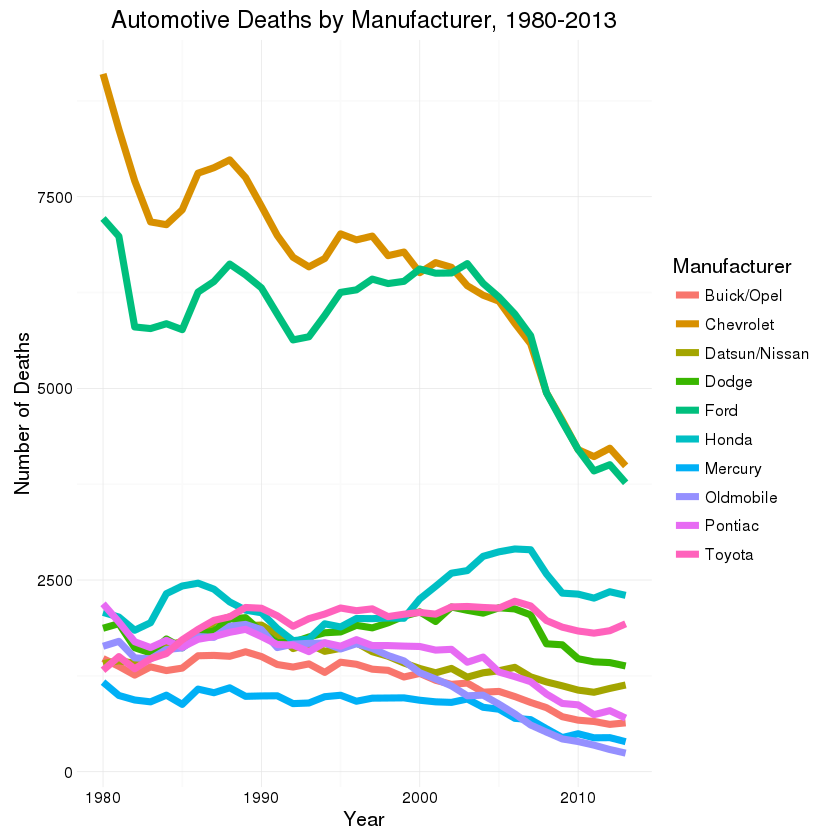

In [10]:
## Only select rows with manufacturers in the top ten
top10mby <- makebyyear[makebyyear$maker %in% makecounts[1:10,]$maker,]

## Build plot
ggplot(top10mby, aes(x = year, y = tot_deaths, color = maker)) + 
  geom_line(size = 2) +
  labs(title = "Automotive Deaths by Manufacturer, 1980-2013",
       x = "Year", 
       y = "Number of Deaths",
       color = "Manufacturer") +
  theme_minimal()

Before you throw away the keys to your Chevy or Ford - this plot is misleading.  It doesn't take into account the number of cars on the road for each manufacturer.  If we divide the total deaths by the percent of records in the data set we can alleviate some of that bias and normalize the data.  That being said, the drop in deaths for Chevy and Ford is quite dramatic!

In [11]:
## Find percent total for each manufacturer
pct_maker <- mutate(makecounts, pct_rows = (total_deaths/nrow(tmp_crashdata)) * 100)

## Round the values for clarity
pct_maker$pct_rows <- round(pct_maker$pct_rows, 2)

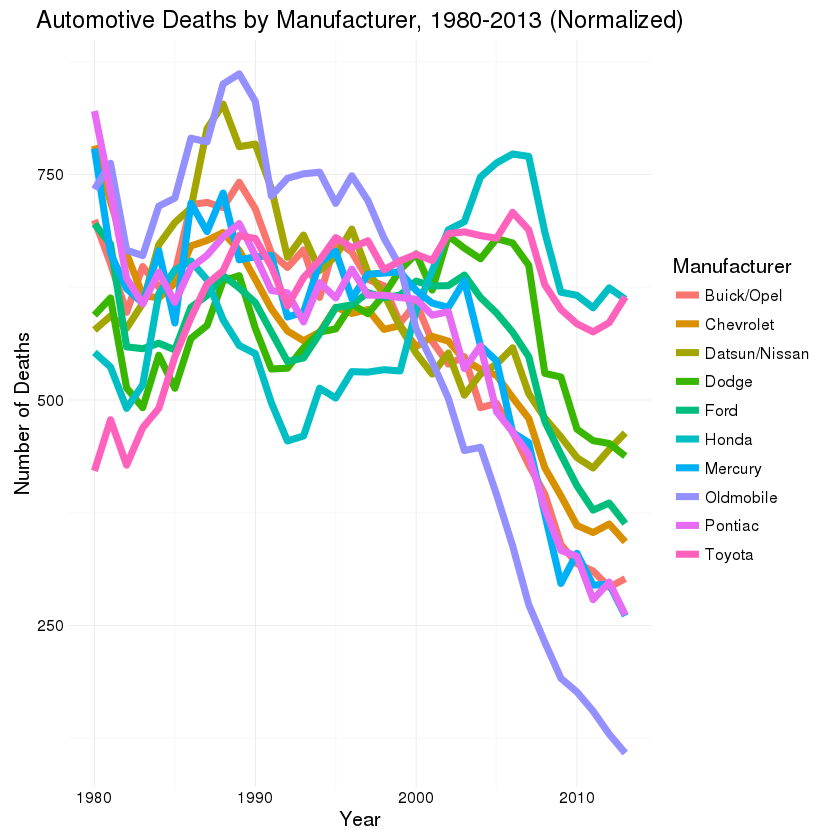

In [12]:
## Combine percent total table with make by year table, add normalized deaths field
makebyyear.norm <- merge(x = makebyyear, y = pct_maker, by ="make", all.x = T) %>% 
  mutate(norm_deaths = tot_deaths/pct_rows)

## Plot Normalized Data
ggplot(makebyyear.norm[makebyyear.norm$make %in% makecounts[1:10, ]$make, ], aes(x = year, y = norm_deaths, color = maker.x)) + 
  geom_line(size = 2) +
  labs(title = "Automotive Deaths by Manufacturer, 1980-2013 (Normalized)",
       x = "Year", 
       y = "Number of Deaths",
      color = "Manufacturer") +
  theme_minimal()


The major discrepancy between Ford, Chevrolet, and the rest of the manufacturers has dissapeared!  Furthermore, there is a strong trend toward a decreasing number of deaths across most manufacturers since the turn of the century.  We can conclude that _based on this data alone, there is no difference in the safety profile of various manufacturers in terms of deaths._  Further analysis is needed to see how they compare in terms of injuries.

___

### Driver - Exploring Dangerous Behaviors

Both popular wisdom and common sense suggest that speeding and drunk driving are dangerous, potentially lethal behaviors.  Since we are working with over 30 years of fatal crash data we can test that hypothesis. 

##### Travel Speed

Let's split up the raw data into three equal sized groups based on travel speed.  Group 1 represents the bottom 33% of travel speeds, group 2 the top 66%, and group 3 the rest.  **Is there a relationship between speed and total deaths?**


In [13]:
## Select travel speed and deaths columns
speedbuckets <- select(sc_crashdata, trav_sp, deaths) %>%
                filter(trav_sp < 997, trav_sp != 99, trav_sp != 98, trav_sp != 0) %>%  ## Remove unknown speeds
                mutate(tertile = ntile(trav_sp, 3)) %>%  ## Create 3 groups based on percentiles
                group_by(tertile) %>%
                summarise(total_deaths = sum(deaths), avg_speed = mean(trav_sp), no_obs = n()) %>% ## Find average speed for each group
                collect() %>% ## Bring back to R
                na.omit()  ## Remove missing values
## Take a peek
head(speedbuckets)

tertile,total_deaths,avg_speed,no_obs
1,126269,27.27685,275766
2,148654,50.39474,275766
3,226645,68.32412,275765


The third group has far more deaths than the other two, slower groups!  Visualizing the distribution of travel speeds and death counts for each group should make this relationship even clearer:

Warning message:
“`geom_bar()` no longer has a `binwidth` parameter. Please use `geom_histogram()` instead.”

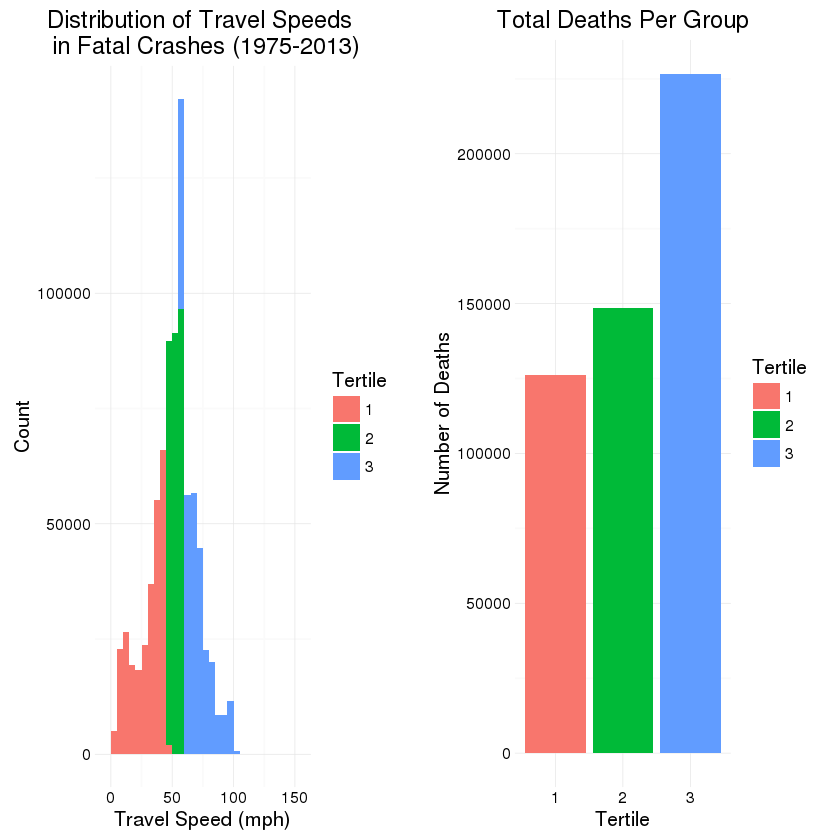

In [14]:
## Select travel speed, deaths, and break travel speed distribution into 3 groups
speed_dist <- select(sc_crashdata, trav_sp, deaths) %>%
                filter(trav_sp < 997, trav_sp != 98, trav_sp != 99, trav_sp != 0) %>%
                mutate(tertile = ntile(trav_sp, 3)) %>%
                collect() %>%
                na.omit()

## Visualize travel speed distribution for each group
p1 <- ggplot(speed_dist, aes(x = trav_sp, fill = factor(tertile))) + 
        geom_bar(position = 'stack', binwidth = 5) + 
        labs(title = "Distribution of Travel Speeds \n in Fatal Crashes (1975-2013)", 
            x = "Travel Speed (mph)", y = "Count", fill = "Tertile") + 
        theme_minimal()

## Total number of deaths for each group
p2 <- ggplot(speedbuckets, aes(x = factor(tertile), y = total_deaths, fill = factor(tertile))) + 
        geom_bar(stat = 'identity', position = 'stack') +
        labs(title = "Total Deaths Per Group", 
            x = "Tertile",
            y = "Number of Deaths",
            fill = "Tertile") + 
        theme_minimal()

## Arrange both plots side by side
grid.arrange(p1,p2, ncol = 2)

There are clearly far more deaths when speeding is involved.

##### Drunk Driving

It would be very surprising if there were no relationship between alcohol intoxication and fatal wrecks.  Nonetheless, let's see what the historical data has to say.  

FARS data only covers accidents where a fatality occurred.  However, not everyone dies in a crash.  Oftentimes in a multi-vehicle accident, only one of the vehicles will possess a fatality.  With that in mind, **what effect does drinking have on whether you will be a survivor or a fatality?**  To answer this question we'll split the data twice - into fatalities and survivors, and into accidents with alcohol and accidents without alcohol.

In [16]:
## Select drunk driving and number of deaths columns, then filter out unknown values
drinking <- select(sc_crashdata, dr_drink, deaths) %>%
            filter(dr_drink < 9) %>%
            collect() %>%  ## Bring back to R from Spark
            na.omit()  ## Remove any missing values

In [17]:
## Split data by survivors and presence of alcohol
drinking$fatality_ind <- ifelse(drinking$deaths > 0, "Fatality", "Survivor")
drinking$dr_drink <- ifelse(drinking$dr_drink == 1, "With Alcohol", "Without Alcohol")

## Summarise the number of observations for each sub-group
drinking <- group_by(drinking, dr_drink, fatality_ind) %>%
            summarise(no_obs = n()) 

drinking

dr_drink,fatality_ind,no_obs
With Alcohol,Fatality,406208
With Alcohol,Survivor,99856
Without Alcohol,Fatality,812104
Without Alcohol,Survivor,882767


Not surprisingly, the group with the lowest number of observations is survivors in a wreck involving alcohol.  Let's visualize this data to make it clearer.

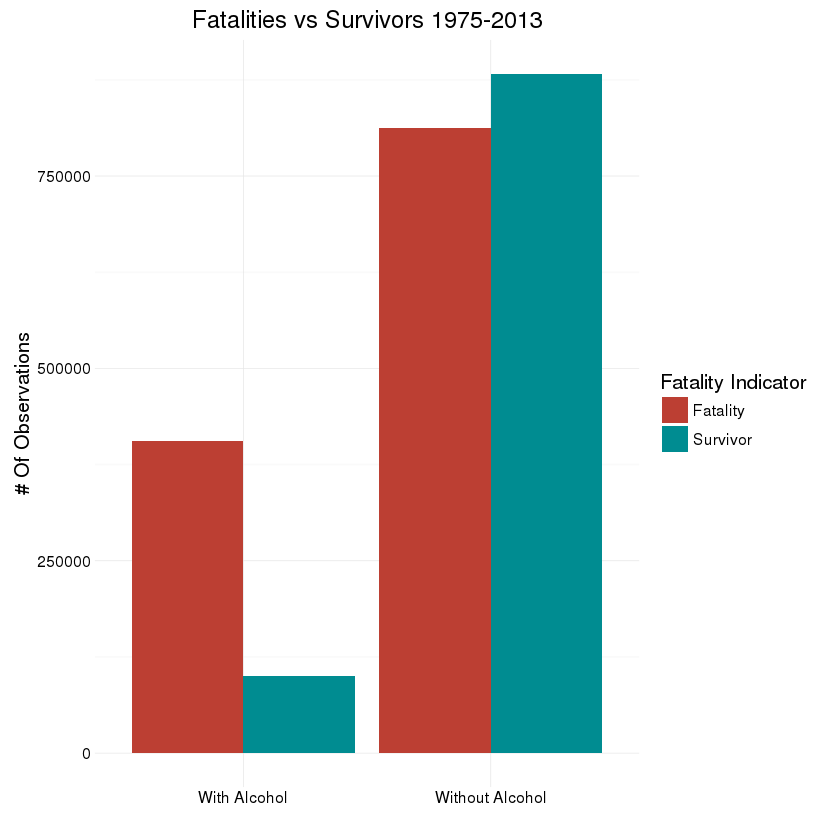

In [18]:
## Plot Observations of Fatalities vs Survivors, split by Presence of Alcohol
ggplot(drinking, aes(x = factor(dr_drink), y = no_obs, fill = factor(fatality_ind))) + 
    geom_bar(stat = "identity", position = 'dodge') +
    labs(title = "Fatalities vs Survivors 1975-2013", 
        x = "",
        y = "# Of Observations",
        fill = "Fatality Indicator") +
    scale_fill_hue(l = 45) +
    theme_minimal()

It appears that in this case, common sense and popular belief are correct.  Don't drink and drive, and watch your speed!

___

### Crash - Choropleth Map

Since 1999, FARS data has included geospatial coordinates.  While we could plot each crash on a map, it is more instructive to take an aggregated look.  If we scale the data by population for each county in the USA we can visualize which counties have a higher fatality rate.

First we load census data from the wonderfully named `noncensus` package.  This will give us the county populations for scaling.  Then we need to ensure that our County and State IDs are identical in format to the census tables.  This is not a trivial task!

In [30]:
## Load census data
data(counties)

## Select columns from historical data for mapping
map_crashdata <- select(sc_crashdata, county, state_x, deaths, key, year) %>%
            filter(year > 1998) %>%
            collect()

## Adjust formatting for FIPS codes - these are unique IDs for each county and state
map_crashdata$county_fips <- sprintf("%03d", map_crashdata$county)
map_crashdata$state_fips <- sprintf("%02d", map_crashdata$state_x)

## Combine crash data with county data
map_crashdata <- merge(x = map_crashdata, y = counties,
                          by = c("state_fips","county_fips"),
                          all.x = TRUE)
## Take a peek 
head(map_crashdata)

state_fips,county_fips,county,state_x,deaths,key,year,county_name,state,fips_class,CSA,CBSA,population
01,000,0,1,0,105922005,2005,NA,NA,NA,NA,NA,NA
01,001,1,1,0,106582000,2000,Autauga County,AL,H1,NA,33860,54571
01,001,1,1,1,102822001,2001,Autauga County,AL,H1,NA,33860,54571
01,001,1,1,0,103982001,2001,Autauga County,AL,H1,NA,33860,54571
01,001,1,1,0,107391999,1999,Autauga County,AL,H1,NA,33860,54571
01,001,1,1,1,101332008,2008,Autauga County,AL,H1,NA,33860,54571


There's our population and fatality data, but what about the spatial data needed to create a map?  Can we join any of these fields together?

In [20]:
## View mapping data
counties <- map_data('county')
head(counties)


 # maps v3.1: updated 'world': all lakes moved to separate new #
 # 'lakes' database. Type '?world' or 'news(package="maps")'.  #




long,lat,group,order,region,subregion
-86.50517,32.34920,1,1,alabama,autauga
-86.53382,32.35493,1,2,alabama,autauga
-86.54527,32.36639,1,3,alabama,autauga
-86.55673,32.37785,1,4,alabama,autauga
-86.57966,32.38357,1,5,alabama,autauga
-86.59111,32.37785,1,6,alabama,autauga


Oof.  There's no matching field right now so we'll have to create one.  Three challenges stand in our way:

1. State name fields are not the same
2. County name fields are not the same
3. Multiple counties have the same name 

So!  Let's work through this step by step until we have an ID variable that we can join our crash data to our map data.  We will create a unique `county_key` comprised of the **full** county name and the state name.

In [1]:
## Bring in states data to fix state name fields
data(states)

## Add state abbreviation to faciliate key creation
map_crashdata <- left_join(map_crashdata, states[, c(1, 2)], by = 'state')

## Create county_key, all lower case with no extra spaces
map_crashdata$county_key <- paste0(tolower(map_crashdata$county_name), tolower(map_crashdata$name))

## Do the same with the map table!
counties$county_key <- ifelse(counties$region != "louisiana", paste0(counties$subregion, " ", "county"),
                            paste0(counties$subregion, " ", "parish"))
counties$county_key <- paste0(counties$county_key, counties$region)

## Check our work
head(select(map_crashdata, deaths, key, population, county_key))
head(counties)

Warning message in data(states):
"data set 'states' not found"

ERROR: Error in eval(expr, envir, enclos): could not find function "left_join"


Alright - we've got our unique key.  Now we can aggregate the number of deaths in each county and scale by population.  We're very close to building that map!

In [22]:
## Group by county_key and get total deaths for each county
county_fatals <- group_by(map_crashdata, county_key) %>%
    summarise(total = sum(deaths))

## Add population for each county, remove duplicate rows, divide total deaths by population
county_fatals <- left_join(county_fatals, map_crashdata[, c("county_key", "population")], by = 'county_key') %>%
    distinct() %>%
    mutate(scaled = (total/population) * 10000)

## Round off scaled deaths
county_fatals$scaled <- round(county_fatals$scaled, 2)

## Remove NA in first row
county_fatals <- county_fatals[-1, ] 

## Join crash aggregations and county demographics with geospatial data
crashmap <- left_join(county_fatals, counties, by = 'county_key') %>%
  mutate(quantile = ntile(scaled, 10))  ## Add column that divides scaled values into 10 groups

head(crashmap)

county_key,total,population,scaled,long,lat,group,order,region,subregion,quantile
abbeville countysouth carolina,70,25417,27.54,-82.24809,34.41758,2285,67181,south carolina,abbeville,5
abbeville countysouth carolina,70,25417,27.54,-82.31685,34.35455,2285,67182,south carolina,abbeville,5
abbeville countysouth carolina,70,25417,27.54,-82.31111,34.33163,2285,67183,south carolina,abbeville,5
abbeville countysouth carolina,70,25417,27.54,-82.31111,34.29152,2285,67184,south carolina,abbeville,5
abbeville countysouth carolina,70,25417,27.54,-82.28247,34.26860,2285,67185,south carolina,abbeville,5
abbeville countysouth carolina,70,25417,27.54,-82.25955,34.25142,2285,67186,south carolina,abbeville,5


_Excellent._  This is the dataframe we can pass to our plotting libraries and build something beautiful!

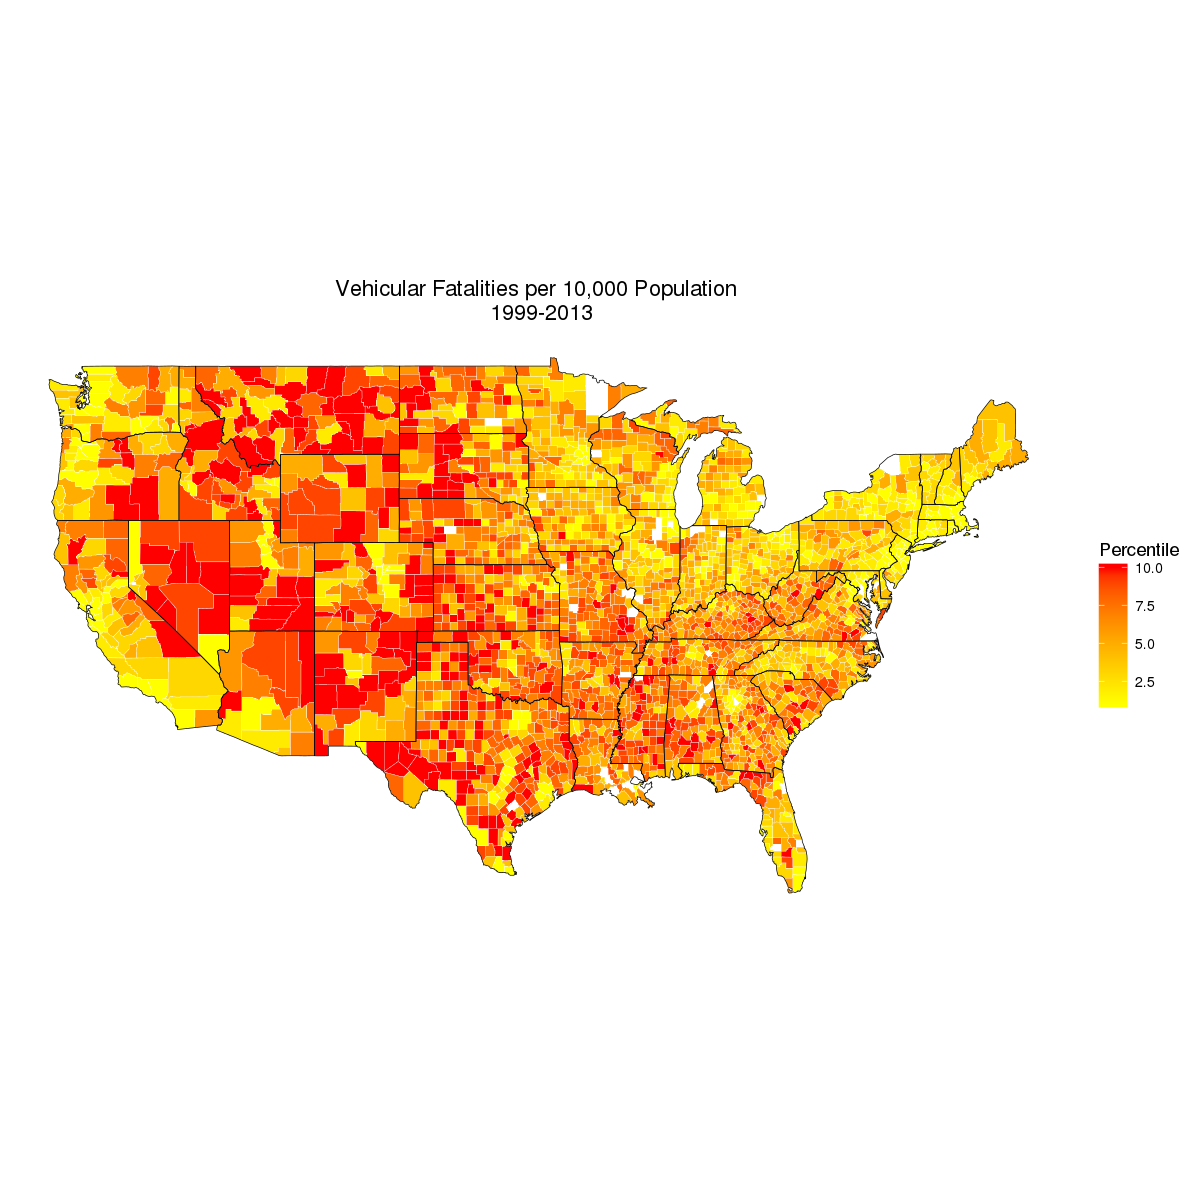

In [23]:
## Load this library and set options to make plot output bigger
library(repr)
options(repr.plot.width=10, repr.plot.height=10)

## Build the map in layers
states <- map_data('state')

ggplot(data = crashmap, 
       mapping = aes(x = long, y = lat, group = group, fill = quantile)) +
  coord_fixed(1.3) +
  scale_fill_gradient(
    name = "Percentile",
    low = "yellow",
    high = "red") +
  geom_polygon(color = 'white', size = 0.1) + 
  geom_polygon(data = states, fill = NA, color = 'black', size = 0.2) +
  theme_nothing(legend = T) +
  labs(title = "Vehicular Fatalities per 10,000 Population \n 1999-2013")


Notice the difference between rural counties and urban ones.  Densely populated areas have less fatal crashes per capita.  Perhaps this is explained by what we have already established in this Notebook.  On rural roads it is easier to speed - and speed kills.  When I first saw these results plotted it surprised me - I thought those crazy inner city drivers would result in hot spots of vehicular death and destruction.  Apparently not. 
___

### Conclusion

In this notebook we explored over 30 years of fatal crash data with assistance from Spark-as-a-Service, IBM Object Storage, and Compose - all available for provisioning at www.bluemix.net.  Of course, the analysis itself was conducted in IBM's Data Science Experience.  Along the way we reinforced some commonly held beliefs and uncovered a surprising finding.  To summarize:

> **_High travel speed and alcohol consumption are consistently involved in fatal crashes._**
>
> **_Perhaps as a result of this, rural roads have more deaths per capita than urban roads._**

Thank you very much for reading this far.  I hope you have learned something from the techniques and libraries that were used in preparing this Notebook.  If you have any questions or corrections to what has been presented here, please contact me at <rafi.kurlansik@ibm.com>.

___

![IBM Logo](http://matemedia.com/wp-content/uploads/2013/11/ibm-logo-transparent-300x143.png)